In [59]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e7/sample_submission.csv
/kaggle/input/playground-series-s5e7/train.csv
/kaggle/input/playground-series-s5e7/test.csv


# Preparation

In [60]:
# Load the data
train_data_path = '../input/playground-series-s5e7/train.csv'
train_data = pd.read_csv(train_data_path)

# Exploration

In [61]:
# Check the distribution of each column
train_data.describe(include='all')

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
count,18524.000000,17334.000000,16631,17344.000000,17058.000000,17375,17470.000000,17260.000000,18524
unique,NaN,NaN,2,NaN,NaN,2,NaN,NaN,2
top,NaN,NaN,No,NaN,NaN,No,NaN,NaN,Extrovert
freq,NaN,NaN,12609,NaN,NaN,13313,NaN,NaN,13699
mean,9261.500000,3.137764,NaN,5.265106,4.044319,NaN,7.996737,4.982097,NaN
std,5347.562529,3.003786,NaN,2.753359,2.062580,NaN,4.223484,2.879139,NaN
min,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN
25%,4630.750000,1.000000,NaN,3.000000,3.000000,NaN,5.000000,3.000000,NaN
50%,9261.500000,2.000000,NaN,5.000000,4.000000,NaN,8.000000,5.000000,NaN
75%,13892.250000,4.000000,NaN,8.000000,6.000000,NaN,12.000000,7.000000,NaN


In [62]:
# Check the count of missing data in each column 
train_data.isna().sum()

id                              0
Time_spent_Alone             1190
Stage_fear                   1893
Social_event_attendance      1180
Going_outside                1466
Drained_after_socializing    1149
Friends_circle_size          1054
Post_frequency               1264
Personality                     0
dtype: int64

In [63]:
# Checking pattern of missing data in each feature
train_data[train_data['Post_frequency'].isna()].head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
4,4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert
14,14,3.0,No,6.0,4.0,No,9.0,NaN,Extrovert
36,36,3.0,No,6.0,3.0,No,7.0,NaN,Extrovert
58,58,8.0,Yes,0.0,2.0,Yes,5.0,NaN,Introvert
80,80,2.0,No,9.0,4.0,No,6.0,NaN,Extrovert


In [64]:
# Create list of features
features = ['Time_spent_Alone', 'Stage_fear', 'Social_event_attendance', 'Going_outside', 'Drained_after_socializing', 'Friends_circle_size', 'Post_frequency']

# Select columns corresponding to features, and preview the data
X = train_data[features]
X.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency
0,0.0,No,6.0,4.0,No,15.0,5.0
1,1.0,No,7.0,3.0,No,10.0,8.0
2,6.0,Yes,1.0,0.0,NaN,3.0,0.0
3,3.0,No,7.0,3.0,No,11.0,5.0
4,1.0,No,4.0,4.0,No,13.0,NaN


In [65]:
# Transforming missing data
def null_transformer(df):
    df_tf = df.copy()
    for x in features:
        df_tf[x+'_null'] = np.where(df[x].isna(), 1, 0)
        df_tf[x] = df[x].fillna(0)
    df_tf['Stage_fear'] = np.where(df_tf['Stage_fear'] == 'Yes', 1, 0)
    df_tf['Drained_after_socializing'] = np.where(df_tf['Drained_after_socializing'] == 'Yes', 1, 0)
    return df_tf
X_tf = null_transformer(X)
X_tf

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Time_spent_Alone_null,Stage_fear_null,Social_event_attendance_null,Going_outside_null,Drained_after_socializing_null,Friends_circle_size_null,Post_frequency_null
0,0.0,0,6.0,4.0,0,15.0,5.0,0,0,0,0,0,0,0
1,1.0,0,7.0,3.0,0,10.0,8.0,0,0,0,0,0,0,0
2,6.0,1,1.0,0.0,0,3.0,0.0,0,0,0,0,1,0,0
3,3.0,0,7.0,3.0,0,11.0,5.0,0,0,0,0,0,0,0
4,1.0,0,4.0,4.0,0,13.0,0.0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18519,3.0,0,7.0,3.0,0,9.0,7.0,0,0,0,0,0,0,0
18520,1.0,0,6.0,7.0,0,6.0,5.0,0,1,0,0,0,0,0
18521,7.0,1,1.0,1.0,1,1.0,0.0,0,0,0,0,0,0,1
18522,0.0,1,1.0,0.0,1,5.0,2.0,1,0,0,0,0,0,0


In [66]:
# Separate the target
y = train_data.Personality
y

0        Extrovert
1        Extrovert
2        Introvert
3        Extrovert
4        Extrovert
           ...    
18519    Extrovert
18520    Extrovert
18521    Introvert
18522    Introvert
18523    Extrovert
Name: Personality, Length: 18524, dtype: object

In [67]:
# Target transformer
def target_transformer(df):
    df_tf = np.where(df == 'Introvert', 1, 0) 
    return df_tf

# Target detransformer
def target_detransformer(df):
    df_tf = np.where(df == 1, 'Introvert', 'Extrovert')
    return df_tf

# Transform target
y_tf = target_transformer(y)
y_tf

# 1 = Introvert, 0 = Extrovert

array([0, 0, 1, ..., 1, 1, 0])

# Model Training 

In [68]:
# Import helpful libraries
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Split into validation and training data
train_X, val_X, train_y, val_y = train_test_split(X_tf, y_tf, random_state=1, test_size=0.2, stratify=y_tf)

# First Model : Decision Tree Classifier

In [69]:
# Import helpful libraries
from sklearn.tree import DecisionTreeClassifier, plot_tree
from matplotlib import pyplot as plt

# Define a random forest model
dt_model = DecisionTreeClassifier(random_state=1, max_depth=4)
dt_model.fit(train_X, train_y)
dt_val_predictions = dt_model.predict(val_X)

In [70]:
# Accuracy score
accuracy_score(val_y, dt_val_predictions)

0.9719298245614035

In [71]:
# Confusion matrix
confusion_matrix(y_true=val_y, y_pred=dt_val_predictions)

array([[2705,   35],
       [  69,  896]])

In [72]:
# Classification report
classification_report(y_true=val_y, y_pred=dt_val_predictions, target_names=['Extrovert', 'Introvert'])

'              precision    recall  f1-score   support\n\n   Extrovert       0.98      0.99      0.98      2740\n   Introvert       0.96      0.93      0.95       965\n\n    accuracy                           0.97      3705\n   macro avg       0.97      0.96      0.96      3705\nweighted avg       0.97      0.97      0.97      3705\n'

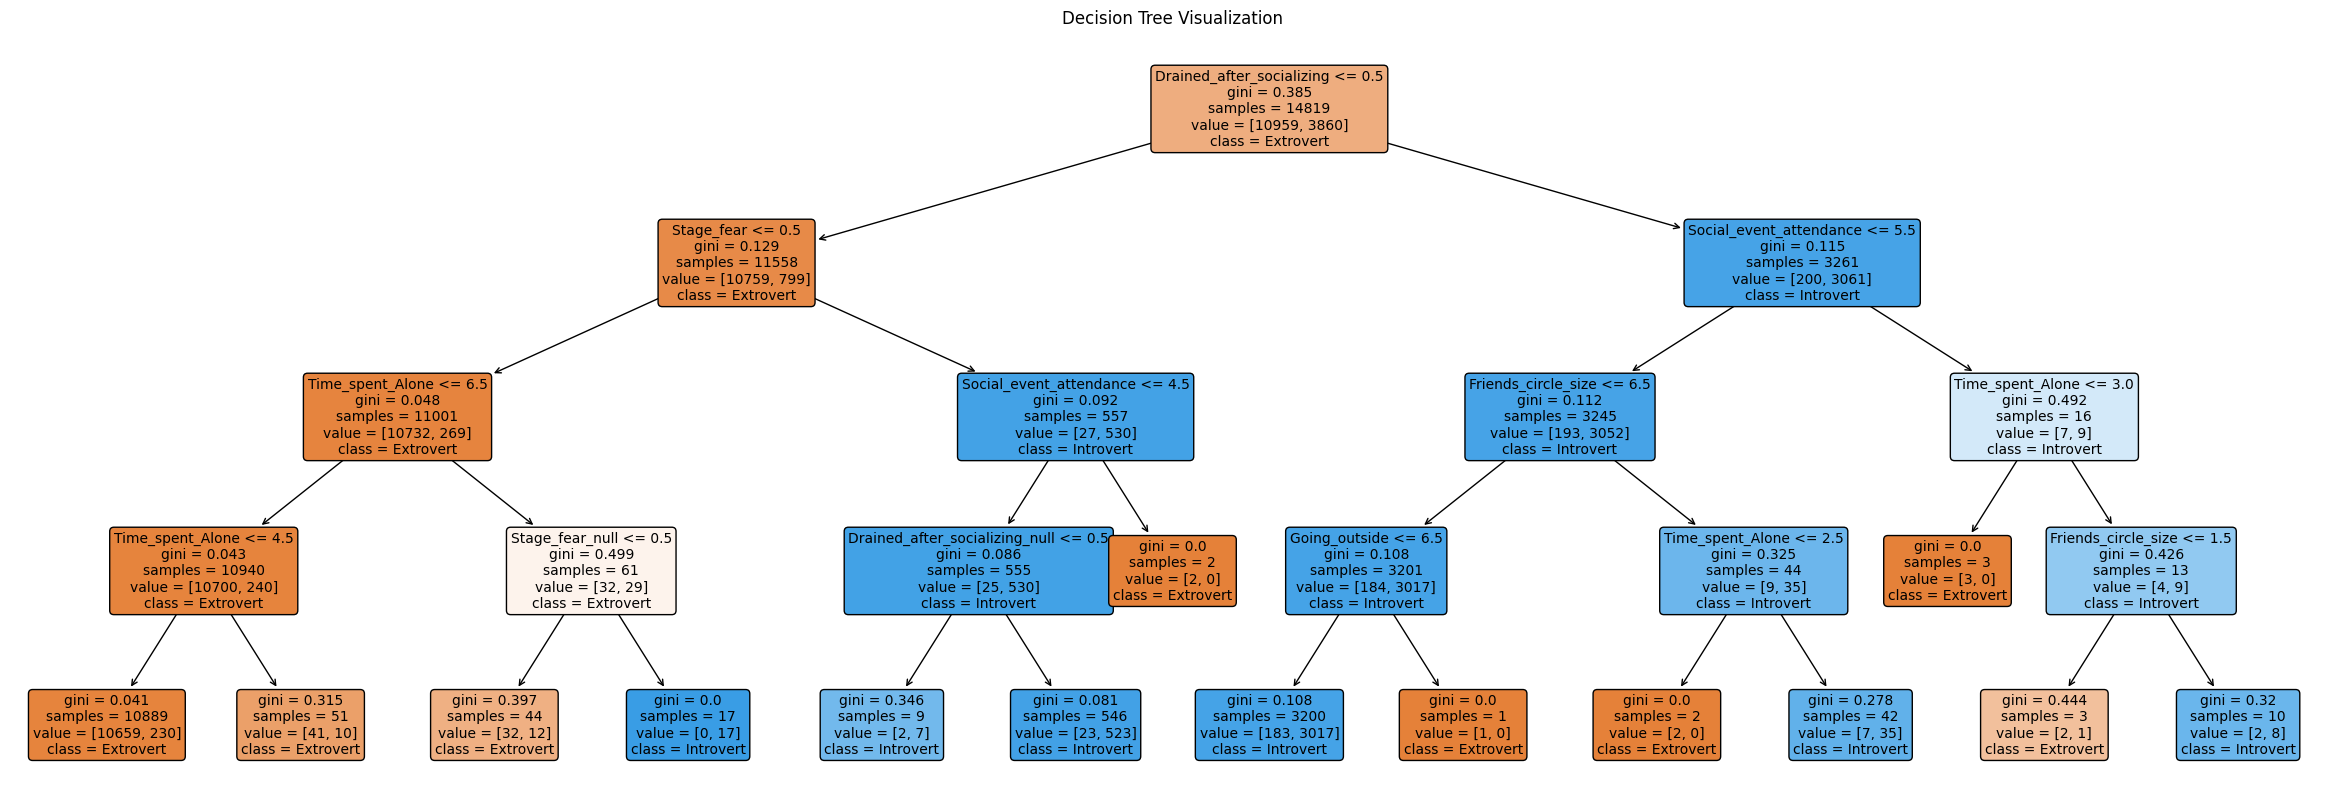

In [73]:
# Tree visualization
plt.figure(figsize=(30, 10))
plot_tree(dt_model, 
          feature_names=train_X.columns, 
          class_names=['Extrovert', 'Introvert'],
          filled=True, 
          rounded=True,
          fontsize=10)
plt.title("Decision Tree Visualization")
plt.show()

# Second Model : Random Forest Classifier

In [74]:
# Import helpful libraries
from sklearn.ensemble import RandomForestClassifier

# Define a random forest model
rf_model = RandomForestClassifier(random_state=1)
rf_model.fit(train_X, train_y)
rf_val_predictions = rf_model.predict(val_X)

In [75]:
# Accuracy score
accuracy_score(val_y, rf_val_predictions)

0.9711201079622133

In [76]:
# Confusion matrix
confusion_matrix(y_true=val_y, y_pred=rf_val_predictions)

array([[2701,   39],
       [  68,  897]])

In [77]:
# Classification report
classification_report(y_true=val_y, y_pred=rf_val_predictions, target_names=['Extrovert', 'Introvert'])

'              precision    recall  f1-score   support\n\n   Extrovert       0.98      0.99      0.98      2740\n   Introvert       0.96      0.93      0.94       965\n\n    accuracy                           0.97      3705\n   macro avg       0.97      0.96      0.96      3705\nweighted avg       0.97      0.97      0.97      3705\n'

Max Testing Accuracy:  0.9713900134952766 , number of trees:  45


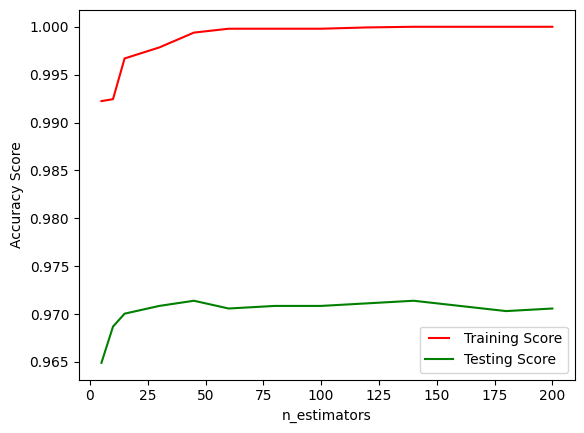

In [78]:
from matplotlib.legend_handler import HandlerLine2D

train_results = []
test_results = []
list_nb_trees = [5, 10, 15, 30, 45, 60, 80, 100, 120, 140, 160, 180, 200]

for nb_trees in list_nb_trees:
    rf = RandomForestClassifier(n_estimators=nb_trees)
    rf.fit(train_X, train_y)

    train_results.append(accuracy_score(train_y, rf.predict(train_X)))
    test_results.append(accuracy_score(val_y, rf.predict(val_X)))

print("Max Testing Accuracy: ", max(test_results), ", number of trees: ", list_nb_trees[np.argmax(test_results)])

line1, = plt.plot(list_nb_trees, train_results, color="r", label="Training Score")
line2, = plt.plot(list_nb_trees, test_results, color="g", label="Testing Score")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Accuracy Score')
plt.xlabel('n_estimators')
plt.show()

# Model Fitting on Submission Data

In [86]:
# To improve accuracy, create a new Random Forest model which you will train on all training data
dt_model_on_full_data = DecisionTreeClassifier(random_state=1, max_depth=4)

# fit rf_model_on_full_data on all data from the training data
dt_model_on_full_data.fit(X_tf, y_tf)

DecisionTreeClassifier(max_depth=4, random_state=1)

# Submission Model Prediction

In [87]:
# Path to file which will be used for predictions
test_data_path = '../input/playground-series-s5e7/test.csv'

# Read test data file using pandas
test_data = pd.read_csv(test_data_path)
test_data.describe()

,id,Time_spent_Alone,Social_event_attendance,Going_outside,Friends_circle_size,Post_frequency
count,6175.000000,5750.000000,5778.000000,5709.000000,5825.000000,5767.000000
mean,21611.000000,3.116870,5.287989,4.037835,8.008412,5.028958
std,1782.713288,2.985658,2.758052,2.045207,4.192701,2.867285
min,18524.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20067.500000,1.000000,3.000000,3.000000,5.000000,3.000000
50%,21611.000000,2.000000,5.000000,4.000000,8.000000,5.000000
75%,23154.500000,4.000000,8.000000,6.000000,12.000000,7.000000
max,24698.000000,11.000000,10.000000,7.000000,15.000000,10.000000


In [88]:
# Create test_X which comes from test_data but includes only the columns used for prediction
# The list of columns is stored in a variable called features
test_X = test_data[features]
test_X.describe()

,Time_spent_Alone,Social_event_attendance,Going_outside,Friends_circle_size,Post_frequency
count,5750.000000,5778.000000,5709.000000,5825.000000,5767.000000
mean,3.116870,5.287989,4.037835,8.008412,5.028958
std,2.985658,2.758052,2.045207,4.192701,2.867285
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,3.000000,3.000000,5.000000,3.000000
50%,2.000000,5.000000,4.000000,8.000000,5.000000
75%,4.000000,8.000000,6.000000,12.000000,7.000000
max,11.000000,10.000000,7.000000,15.000000,10.000000


In [89]:
# Transform the test data
test_X_tf = null_transformer(test_X)
test_X_tf.describe()

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Time_spent_Alone_null,Stage_fear_null,Social_event_attendance_null,Going_outside_null,Drained_after_socializing_null,Friends_circle_size_null,Post_frequency_null
count,6175.000000,6175.000000,6175.000000,6175.000000,6175.000000,6175.000000,6175.000000,6175.000000,6175.000000,6175.000000,6175.000000,6175.000000,6175.000000,6175.000000
mean,2.902348,0.217166,4.948016,3.733117,0.211498,7.554494,4.696680,0.068826,0.096842,0.064291,0.075466,0.069960,0.056680,0.066073
std,2.987180,0.412350,2.966510,2.237161,0.408404,4.473465,3.039554,0.253178,0.295767,0.245291,0.264163,0.255099,0.231249,0.248430
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,3.000000,2.000000,0.000000,4.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,0.000000,5.000000,4.000000,0.000000,8.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.000000,0.000000,7.000000,6.000000,0.000000,11.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,11.000000,1.000000,10.000000,7.000000,1.000000,15.000000,10.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [90]:
# Make predictions which will be submitted 
test_preds_tf = dt_model_on_full_data.predict(test_X_tf)
print(test_preds_tf)

[0 1 0 ... 0 0 1]


In [91]:
# Detransform the predictions
test_preds = target_detransformer(test_preds_tf)
test_preds

array(['Extrovert', 'Introvert', 'Extrovert', ..., 'Extrovert',
       'Extrovert', 'Introvert'], dtype='<U9')

# Submission

In [92]:
# Save predictions in the format used for competition scoring

output = pd.DataFrame({'id': test_data.id,
                       'Personality': test_preds})
output.to_csv('submission.csv', index=False)